In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Use CPU only to avoid GPU-related import errors
device = torch.device("cpu")

# ------------------------
# Data Preprocessing
# ------------------------

# Load orientation data (path provided by user)
ori_path = "/kaggle/input/gamma-data/DC3_final_530km_3_month_with_slew_15sbins_EarthLocal.ori"
ori_df = pd.read_csv(
    ori_path,
    delim_whitespace=True,
    skiprows=1,
    header=None,
    names=["prefix", "timestamp", "x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
)
ori_df = ori_df.drop(columns=["prefix"])
ori_df["timestamp"] = pd.to_datetime(ori_df["timestamp"], unit='s')

# Load detector data
time_array = np.load("/kaggle/input/gamma-data/time_array.npy")
rates = np.squeeze(np.load("/kaggle/input/gamma-data/total_rates.npy"))
time_series = pd.to_datetime(time_array, unit='s')
rates_df = pd.DataFrame(rates, columns=[f"detector_{i+1}" for i in range(rates.shape[1])])
rates_df["timestamp"] = time_series



/tmp/ipykernel_31/580234434.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ori_df = pd.read_csv(


In [26]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # For GPU
    torch.backends.cudnn.deterministic = True  # Slower, but reproducible
    torch.backends.cudnn.benchmark = False

In [27]:
set_seed(42)

(5761, 7)
(2640, 7)


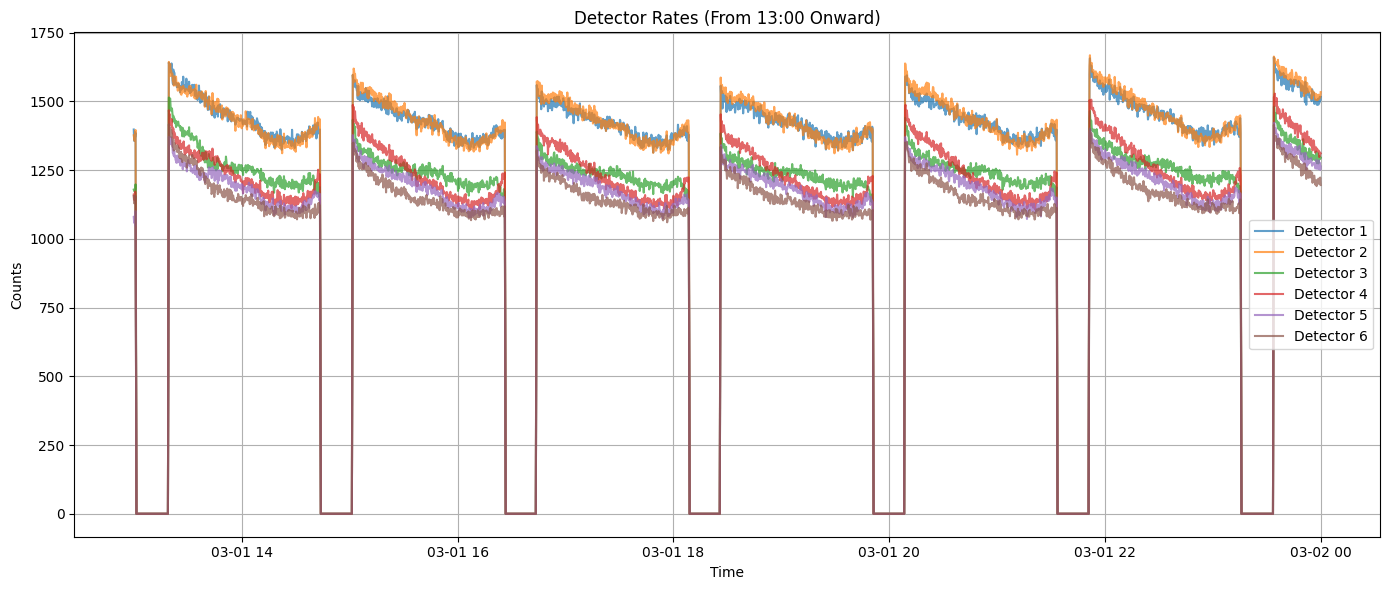

In [28]:
# Filter all days from 13:00 to 00:00
print(rates_df.shape)
rates_df = rates_df[rates_df["timestamp"].dt.hour >= 13]
print(rates_df.shape)
# Plot all 6 detectors after filtering to 13:00 onward
plt.figure(figsize=(14, 6))
for i in range(1, 7):
    plt.plot(rates_df["timestamp"], rates_df[f"detector_{i}"], label=f"Detector {i}", alpha=0.7)

plt.title("Detector Rates (From 13:00 Onward)")
plt.xlabel("Time")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ori_df = ori_df.dropna(subset=["timestamp"])

In [29]:
# Merge orientation with detector data
merged_df = pd.merge_asof(
    rates_df.sort_values("timestamp"),
    ori_df.sort_values("timestamp"),
    on="timestamp"
).dropna()

In [30]:
merged_df["hour"] = merged_df["timestamp"].dt.hour + merged_df["timestamp"].dt.minute / 60
#merged_df["sin_time"] = np.sin(2 * np.pi * merged_df["hour"] / 24)
##erged_df["cos_time"] = np.cos(2 * np.pi * merged_df["hour"] / 24)


In [31]:
# Parameters
WINDOW_SIZE = 10
EPOCHS = 200
learning_rate= 1e-3#5*1e-5
epochs_no_improve = 10
early_stopping_patience = 10

def create_windowed_data(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i - window_size:i].flatten())  # flatten the window
        y_seq.append(y[i])  # predict current target
    return np.array(X_seq), np.array(y_seq)

In [33]:
# Extract features and targets again from merged_df
orientation_features = ["x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
#time_features = ["sin_time", "cos_time"]
feature_cols = orientation_features# + time_features
target_cols = [col for col in merged_df.columns if col.startswith("detector_")]

X_all = merged_df[feature_cols].values
y_all = merged_df[target_cols].values

# Normalize features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

y_scaler = StandardScaler()
y_all_scaled = y_scaler.fit_transform(y_all)

# Create windowed sequences again with scaled y
X_seq, y_seq = create_windowed_data(X_all_scaled, y_all_scaled, WINDOW_SIZE)

In [34]:
# Create windowed sequences again with scaled y
X_seq, y_seq = create_windowed_data(X_all_scaled, y_all_scaled, WINDOW_SIZE)

# Split again
split_index = int(len(X_seq) * 0.7)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]



In [35]:
# Dataset and model
class WindowedDetectorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(WindowedDetectorDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
test_loader = DataLoader(WindowedDetectorDataset(X_test_seq, y_test_seq), batch_size=64, shuffle=False)

class FeedforwardWindowed(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, output_dim)
        self.log_sigma = nn.Linear(32, output_dim)

    def forward(self, x):
        h = self.model(x)
        mu = self.mu(h)
        sigma = torch.exp(self.log_sigma(h))
        #sigma = torch.clamp(sigma, min=1e-3)
        return mu, sigma

# Loss and training
def gaussian_nll(y_true, mu, sigma):
    return torch.mean(0.5 * torch.log(2 * torch.pi * sigma ** 2) + 0.5 * ((y_true - mu) ** 2) / (sigma ** 2))

In [36]:
# Redefine datasets and loaders
train_loader = DataLoader(WindowedDetectorDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
test_loader = DataLoader(WindowedDetectorDataset(X_test_seq, y_test_seq), batch_size=64, shuffle=False)

In [37]:
# Retrain the model with same architecture
model = FeedforwardWindowed(X_train_seq.shape[1], y_train_seq.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
best_loss = float('inf')
best_model_path = "best_model.pt"

losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        mu, sigma = model(xb)
        sigma = torch.clamp(sigma, min=1e-3)
        loss = gaussian_nll(yb, mu, sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    losses.append(mean_loss)
    print(f"Epoch {epoch+1}: Loss = {mean_loss:.4f}")

    # Early stopping logic
    if mean_loss < best_loss - 1e-4:  # a small delta to avoid noise
        best_loss = mean_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model.")

# Load best model after training
model.load_state_dict(torch.load(best_model_path))

In [20]:
# Evaluate
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    mu_pred, sigma_pred = model(X_test_tensor)
    mu_pred = mu_pred.cpu().numpy()
    sigma_pred = sigma_pred.cpu().numpy()

# Invert scaling of predictions and targets
mu_pred_inv = y_scaler.inverse_transform(mu_pred)
y_test_inv = y_scaler.inverse_transform(y_test_seq)
sigma_pred_inv = sigma_pred * y_scaler.scale_  # approximate inverse scaling

# Compute MSE
mse = mean_squared_error(y_test_inv, mu_pred_inv)
print(f"\nWindowed MSE on test (30% holdout, normalized target): {mse:.4f}")




Windowed MSE on test (30% holdout, normalized target): 2863.8994


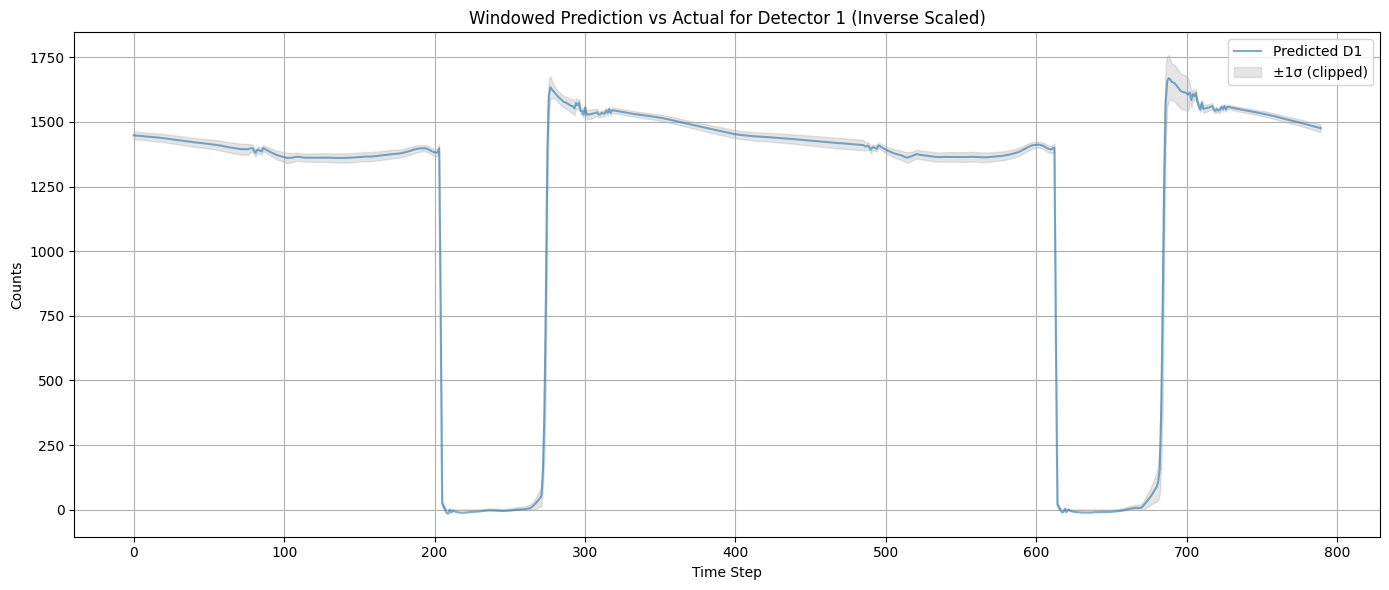

In [21]:
# Plot predictions for Detector 1

x_range = np.arange(len(mu_pred_inv))
plt.figure(figsize=(14, 6))
#plt.plot(x_range, y_test_inv[:, 0], label="Actual D1", alpha=0.6)
plt.plot(x_range, mu_pred_inv[:, 0], label="Predicted D1", alpha=0.6)
lower_bound = np.clip(mu_pred_inv[:, 0] - sigma_pred_inv[:, 0], a_min=0, a_max=2000)
upper_bound = np.clip(mu_pred_inv[:, 0] + sigma_pred_inv[:, 0], a_min=0, a_max=2000)

plt.fill_between(
    x_range,
    lower_bound,
    upper_bound,
    color='gray', alpha=0.2, label="±1σ (clipped)"
)
plt.title("Windowed Prediction vs Actual for Detector 1 (Inverse Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Counts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

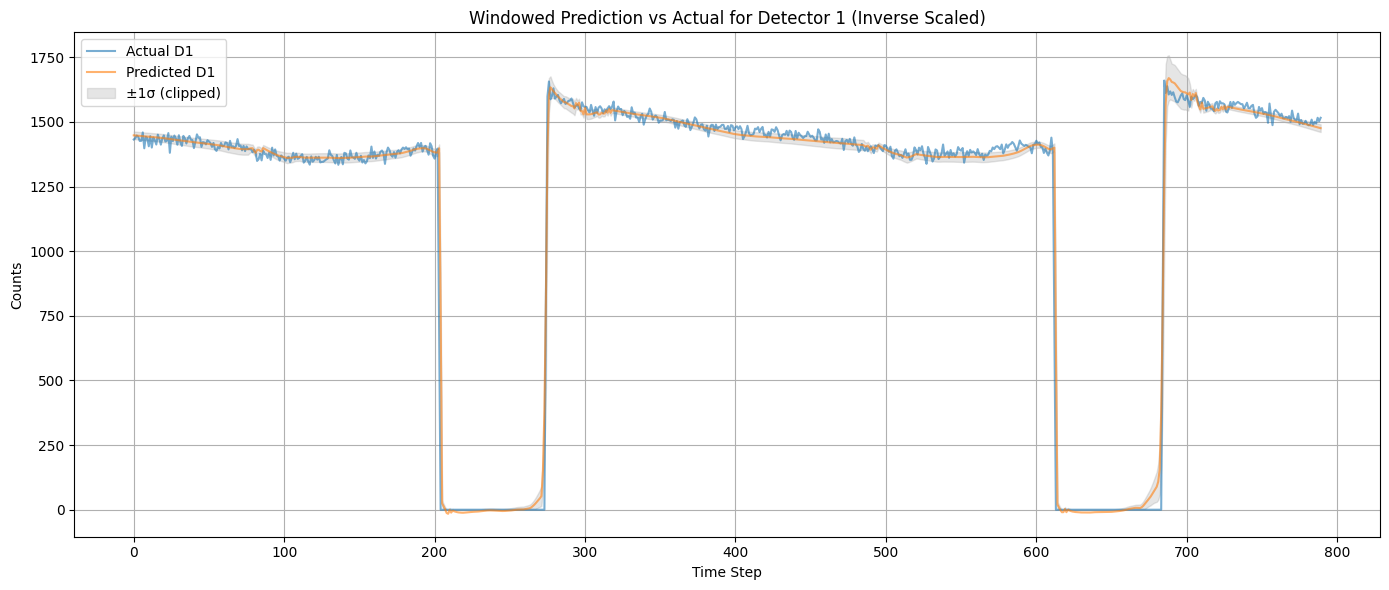

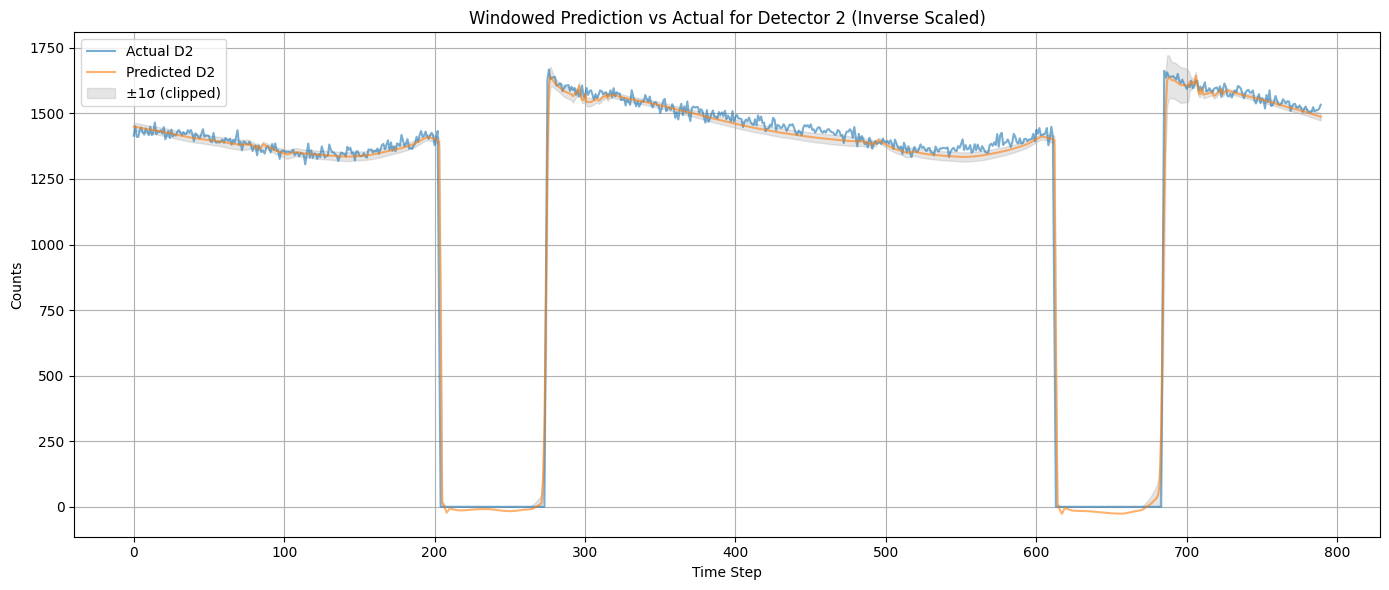

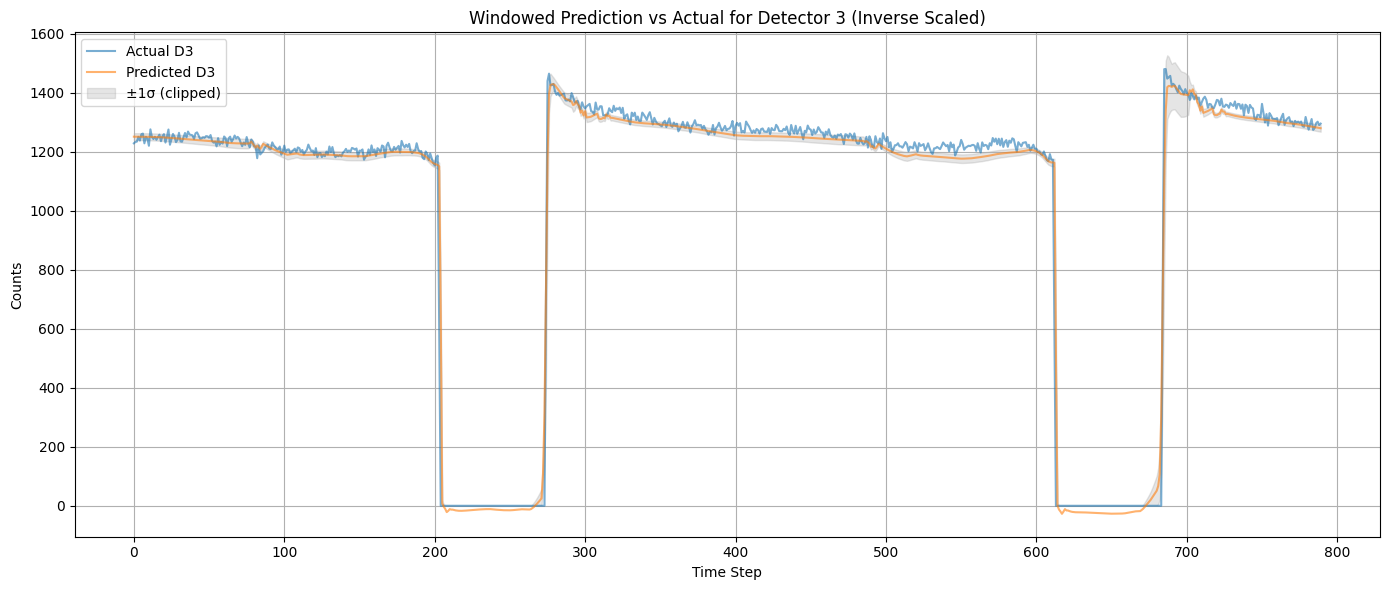

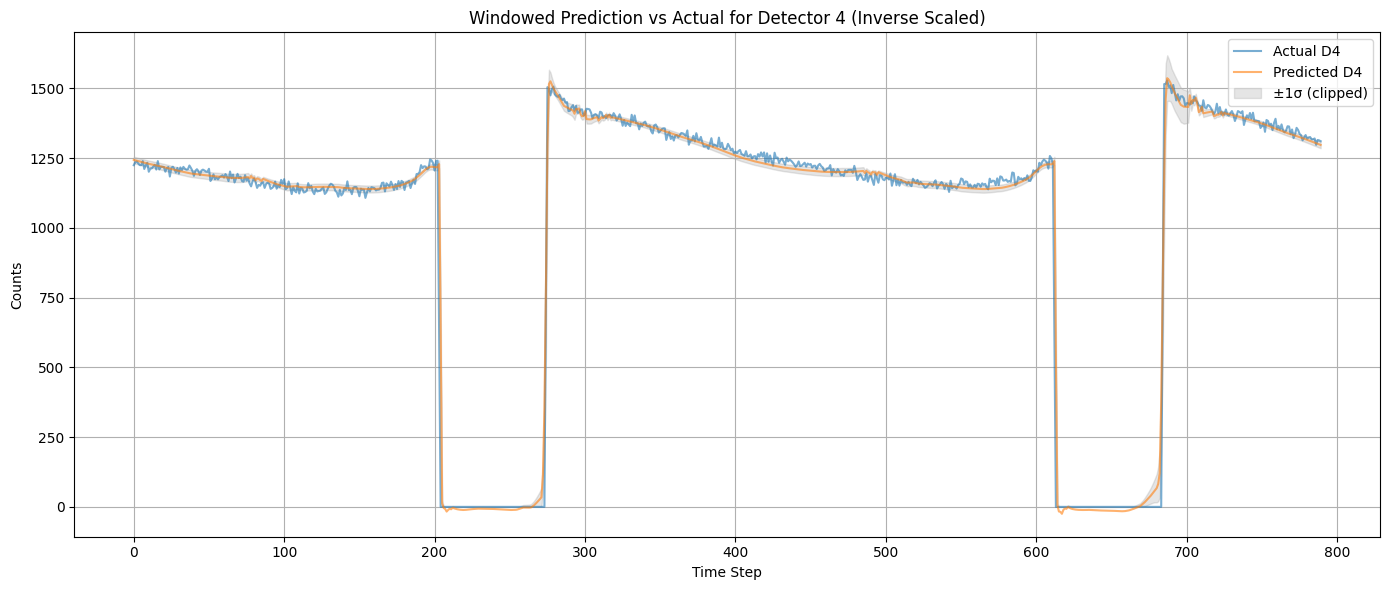

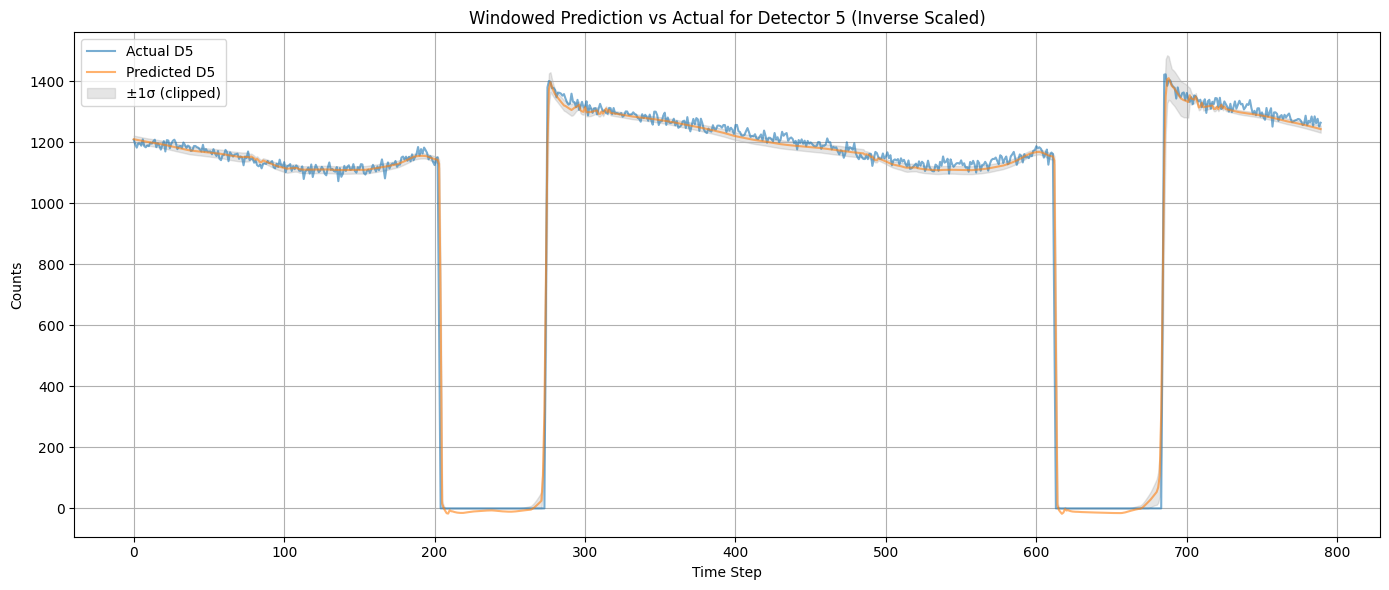

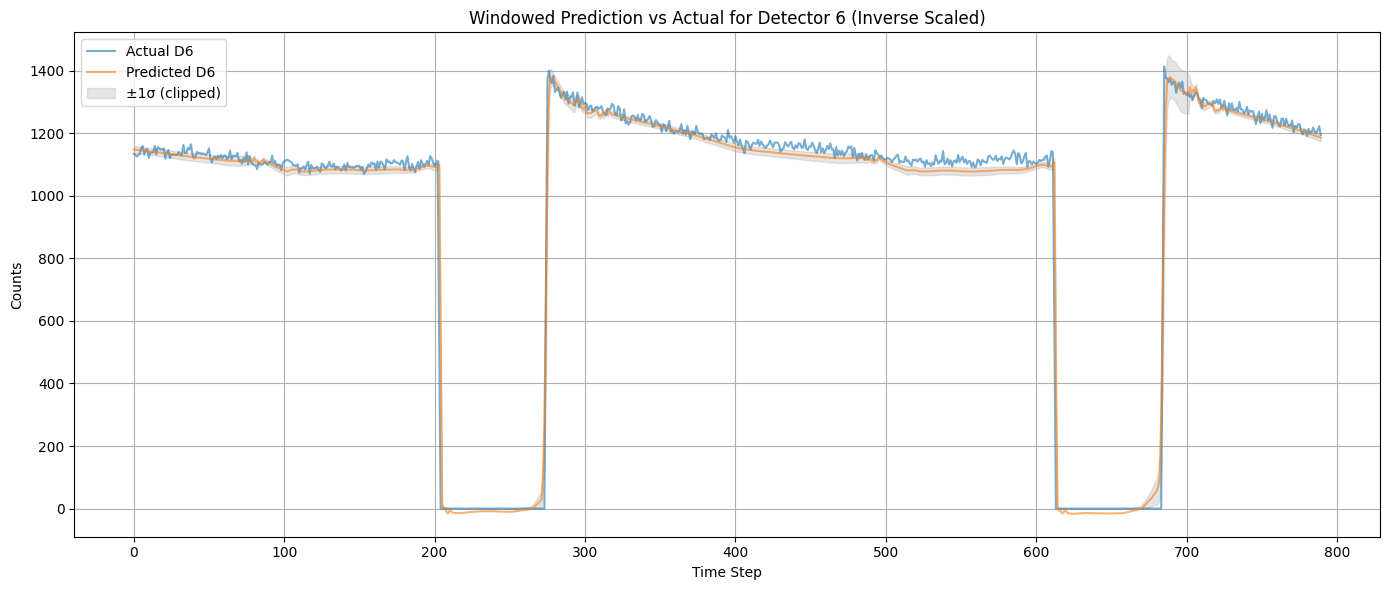

In [24]:
for i in range(6):  # Detectors 0 to 5 (i.e., Detector 1 to Detector 6)
    x_range = np.arange(len(mu_pred_inv))
    plt.figure(figsize=(14, 6))
    
    plt.plot(x_range, y_test_inv[:, i], label=f"Actual D{i+1}", alpha=0.6)
    plt.plot(x_range, mu_pred_inv[:, i], label=f"Predicted D{i+1}", alpha=0.6)
    
    lower_bound = np.clip(mu_pred_inv[:, i] - sigma_pred_inv[:, i], a_min=0, a_max=2000)
    upper_bound = np.clip(mu_pred_inv[:, i] + sigma_pred_inv[:, i], a_min=0, a_max=2000)
    
    plt.fill_between(
        x_range,
        lower_bound,
        upper_bound,
        color='gray', alpha=0.2, label="±1σ (clipped)"
    )
    
    plt.title(f"Windowed Prediction vs Actual for Detector {i+1} (Inverse Scaled)")
    plt.xlabel("Time Step")
    plt.ylabel("Counts")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Removing the 0 counts
To improve the prediction at the edges let's remove the windows of data with 0 count.

In [38]:
# Remove all rows from merged_df where any detector column has a 0 count
merged_df_no_zeros = merged_df[(merged_df[target_cols] != 0).all(axis=1)]
print(f"Original shape: {merged_df.shape}, After removing zeros: {merged_df_no_zeros.shape}")

Original shape: (2640, 15), After removing zeros: (2153, 15)


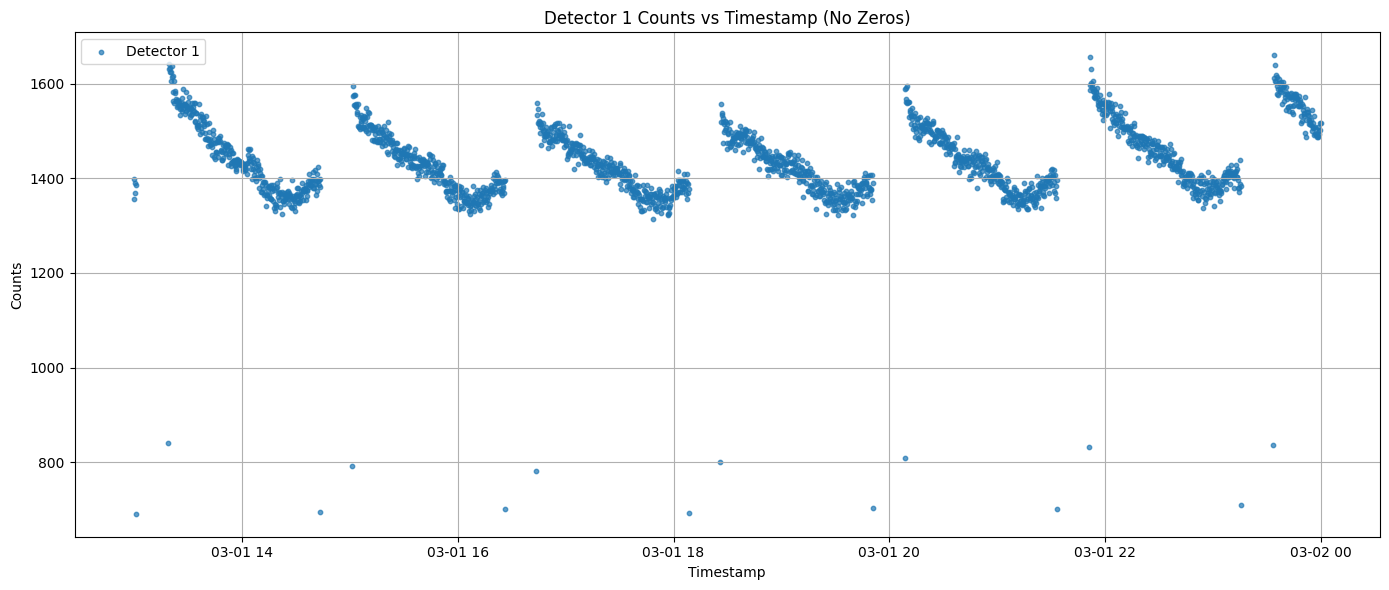

In [39]:
plt.figure(figsize=(14, 6))
plt.scatter(merged_df_no_zeros["timestamp"], merged_df_no_zeros["detector_1"], label="Detector 1", s=10, alpha=0.7)
plt.title("Detector 1 Counts vs Timestamp (No Zeros)")
plt.xlabel("Timestamp")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
X_all = merged_df_no_zeros[feature_cols].values
y_all = merged_df_no_zeros[target_cols].values

# Normalize features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

y_scaler = StandardScaler()
y_all_scaled = y_scaler.fit_transform(y_all)

# Create windowed sequences again with scaled y
X_seq, y_seq = create_windowed_data(X_all_scaled, y_all_scaled, WINDOW_SIZE)

In [41]:
# Split again
split_index = int(len(X_seq) * 0.7)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

In [42]:
# Redefine datasets and loaders
train_loader = DataLoader(WindowedDetectorDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
test_loader = DataLoader(WindowedDetectorDataset(X_test_seq, y_test_seq), batch_size=64, shuffle=False)

In [43]:
# Retrain the model with same architecture
model = FeedforwardWindowed(X_train_seq.shape[1], y_train_seq.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
best_loss = float('inf')
best_model_path = "best_model.pt"

losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        mu, sigma = model(xb)
        sigma = torch.clamp(sigma, min=1e-3)
        loss = gaussian_nll(yb, mu, sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    losses.append(mean_loss)
    print(f"Epoch {epoch+1}: Loss = {mean_loss:.4f}")

    # Early stopping logic
    if mean_loss < best_loss - 1e-4:  # a small delta to avoid noise
        best_loss = mean_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model.")

# Load best model after training
model.load_state_dict(torch.load(best_model_path))

Epoch 1: Loss = 1.1955
Saved best model.
Epoch 2: Loss = 0.4796
Saved best model.
Epoch 3: Loss = 0.0180
Saved best model.
Epoch 4: Loss = -0.1392
Saved best model.
Epoch 5: Loss = -0.2277
Saved best model.
Epoch 6: Loss = -0.2683
Saved best model.
Epoch 7: Loss = -0.2865
Saved best model.
Epoch 8: Loss = -0.2820
Epoch 9: Loss = -0.3123
Saved best model.
Epoch 10: Loss = -0.3177
Saved best model.
Epoch 11: Loss = -0.3469
Saved best model.
Epoch 12: Loss = -0.3533
Saved best model.
Epoch 13: Loss = -0.3879
Saved best model.
Epoch 14: Loss = -0.3940
Saved best model.
Epoch 15: Loss = -0.3890
Epoch 16: Loss = -0.3959
Saved best model.
Epoch 17: Loss = -0.4014
Saved best model.
Epoch 18: Loss = -0.4136
Saved best model.
Epoch 19: Loss = -0.4103
Epoch 20: Loss = -0.4208
Saved best model.
Epoch 21: Loss = -0.4305
Saved best model.
Epoch 22: Loss = -0.4142
Epoch 23: Loss = -0.4108
Epoch 24: Loss = -0.4241
Epoch 25: Loss = -0.4287
Epoch 26: Loss = -0.4298
Epoch 27: Loss = -0.4479
Saved best mo

/tmp/ipykernel_31/3345751514.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [45]:
# Evaluate
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    mu_pred, sigma_pred = model(X_test_tensor)
    mu_pred = mu_pred.cpu().numpy()
    sigma_pred = sigma_pred.cpu().numpy()

# Invert scaling of predictions and targets
mu_pred_inv = y_scaler.inverse_transform(mu_pred)
y_test_inv = y_scaler.inverse_transform(y_test_seq)
sigma_pred_inv = sigma_pred * y_scaler.scale_  # approximate inverse scaling

# Compute MSE
mse = mean_squared_error(y_test_inv, mu_pred_inv)
print(f"\nWindowed MSE on test (30% holdout, normalized target): {mse:.4f}")


Windowed MSE on test (30% holdout, normalized target): 1804.5040


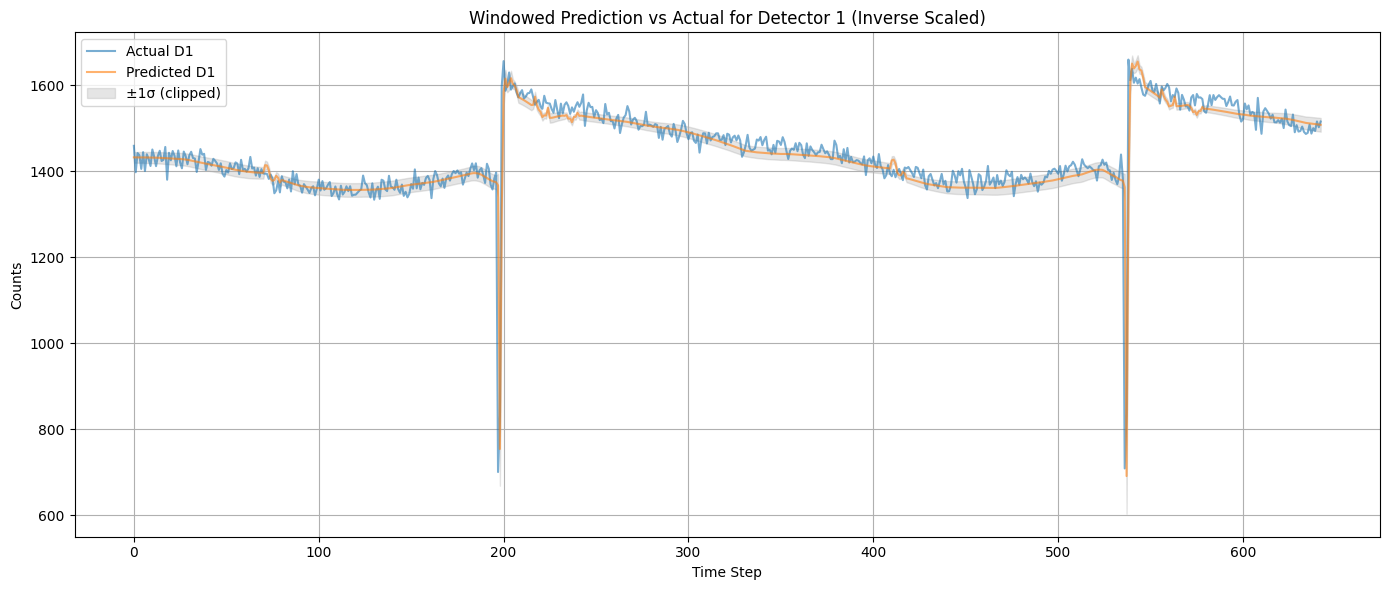

In [46]:
# Plot predictions for Detector 1

x_range = np.arange(len(mu_pred_inv))
plt.figure(figsize=(14, 6))
plt.plot(x_range, y_test_inv[:, 0], label="Actual D1", alpha=0.6)
plt.plot(x_range, mu_pred_inv[:, 0], label="Predicted D1", alpha=0.6)
lower_bound = np.clip(mu_pred_inv[:, 0] - sigma_pred_inv[:, 0], a_min=0, a_max=2000)
upper_bound = np.clip(mu_pred_inv[:, 0] + sigma_pred_inv[:, 0], a_min=0, a_max=2000)

plt.fill_between(
    x_range,
    lower_bound,
    upper_bound,
    color='gray', alpha=0.2, label="±1σ (clipped)"
)
plt.title("Windowed Prediction vs Actual for Detector 1 (Inverse Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Counts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Removing values around 800
The detections signals around 800, which are exactly one before and after adjusting satellite's position, are likely worsening the prediction at the edges.

In [47]:
# Remove all rows where any detector column has a count lower than 1000
merged_df_clean = merged_df_no_zeros[(merged_df_no_zeros[target_cols] >= 1000).all(axis=1)]
print(f"Original shape: {merged_df_no_zeros.shape}, After removing <1000: {merged_df_clean.shape}")

Original shape: (2153, 15), After removing <1000: (2139, 15)


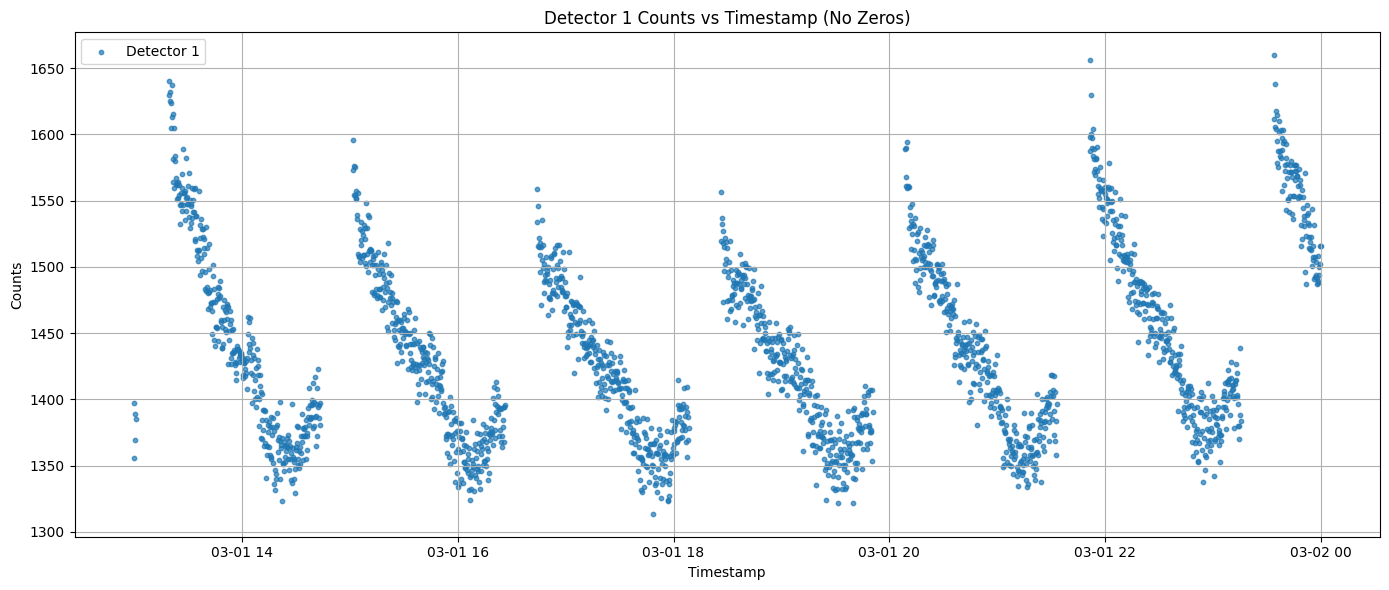

In [48]:
plt.figure(figsize=(14, 6))
plt.scatter(merged_df_clean["timestamp"], merged_df_clean["detector_1"], label="Detector 1", s=10, alpha=0.7)
plt.title("Detector 1 Counts vs Timestamp (No Zeros)")
plt.xlabel("Timestamp")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
X_all = merged_df_clean[feature_cols].values
y_all = merged_df_clean[target_cols].values

# Normalize features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

y_scaler = StandardScaler()
y_all_scaled = y_scaler.fit_transform(y_all)

# Create windowed sequences again with scaled y
X_seq, y_seq = create_windowed_data(X_all_scaled, y_all_scaled, WINDOW_SIZE)

# Split again
split_index = int(len(X_seq) * 0.7)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

# Redefine datasets and loaders
train_loader = DataLoader(WindowedDetectorDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
test_loader = DataLoader(WindowedDetectorDataset(X_test_seq, y_test_seq), batch_size=64, shuffle=False)

# Retrain the model with same architecture
model = FeedforwardWindowed(X_train_seq.shape[1], y_train_seq.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [50]:
best_loss = float('inf')
best_model_path = "best_model.pt"

losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        mu, sigma = model(xb)
        sigma = torch.clamp(sigma, min=1e-3)
        loss = gaussian_nll(yb, mu, sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    losses.append(mean_loss)
    print(f"Epoch {epoch+1}: Loss = {mean_loss:.4f}")

    # Early stopping logic
    if mean_loss < best_loss - 1e-4:  # a small delta to avoid noise
        best_loss = mean_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model.")

# Load best model after training
model.load_state_dict(torch.load(best_model_path))

Epoch 1: Loss = 1.1678
Saved best model.
Epoch 2: Loss = 0.4441
Saved best model.
Epoch 3: Loss = 0.0597
Saved best model.
Epoch 4: Loss = -0.0391
Saved best model.
Epoch 5: Loss = -0.0864
Saved best model.
Epoch 6: Loss = -0.0867
Saved best model.
Epoch 7: Loss = -0.1381
Saved best model.
Epoch 8: Loss = -0.1676
Saved best model.
Epoch 9: Loss = -0.1893
Saved best model.
Epoch 10: Loss = -0.2058
Saved best model.
Epoch 11: Loss = -0.2014
Epoch 12: Loss = -0.2233
Saved best model.
Epoch 13: Loss = -0.2298
Saved best model.
Epoch 14: Loss = -0.2329
Saved best model.
Epoch 15: Loss = -0.2281
Epoch 16: Loss = -0.2443
Saved best model.
Epoch 17: Loss = -0.2341
Epoch 18: Loss = -0.2525
Saved best model.
Epoch 19: Loss = -0.2369
Epoch 20: Loss = -0.2592
Saved best model.
Epoch 21: Loss = -0.2423
Epoch 22: Loss = -0.2243
Epoch 23: Loss = -0.2451
Epoch 24: Loss = -0.2622
Saved best model.
Epoch 25: Loss = -0.2746
Saved best model.
Epoch 26: Loss = -0.2674
Epoch 27: Loss = -0.2776
Saved best mo

/tmp/ipykernel_31/3345751514.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [51]:
# Evaluate
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    mu_pred, sigma_pred = model(X_test_tensor)
    mu_pred = mu_pred.cpu().numpy()
    sigma_pred = sigma_pred.cpu().numpy()

# Invert scaling of predictions and targets
mu_pred_inv = y_scaler.inverse_transform(mu_pred)
y_test_inv = y_scaler.inverse_transform(y_test_seq)
sigma_pred_inv = sigma_pred * y_scaler.scale_  # approximate inverse scaling

# Compute MSE
mse = mean_squared_error(y_test_inv, mu_pred_inv)
print(f"\nWindowed MSE on test (30% holdout, normalized target): {mse:.4f}")


Windowed MSE on test (30% holdout, normalized target): 482.7969


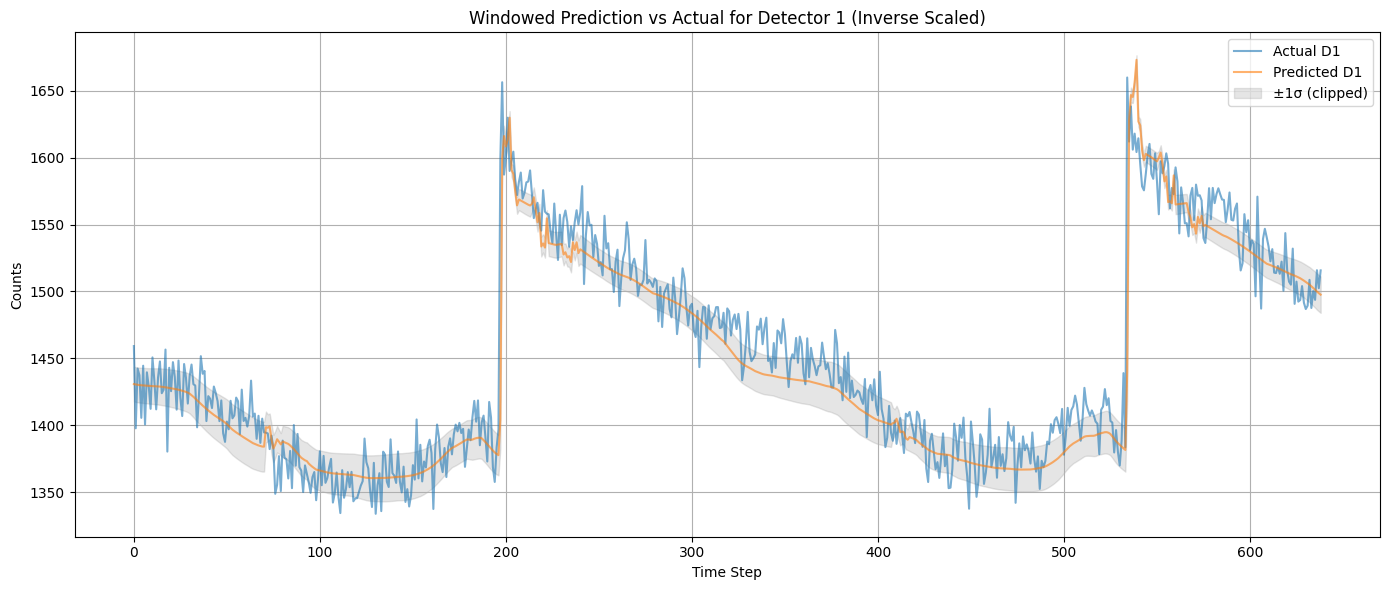

In [52]:
# Plot predictions for Detector 1

x_range = np.arange(len(mu_pred_inv))
plt.figure(figsize=(14, 6))
plt.plot(x_range, y_test_inv[:, 0], label="Actual D1", alpha=0.6)
plt.plot(x_range, mu_pred_inv[:, 0], label="Predicted D1", alpha=0.6)
lower_bound = np.clip(mu_pred_inv[:, 0] - sigma_pred_inv[:, 0], a_min=0, a_max=2000)
upper_bound = np.clip(mu_pred_inv[:, 0] + sigma_pred_inv[:, 0], a_min=0, a_max=2000)

plt.fill_between(
    x_range,
    lower_bound,
    upper_bound,
    color='gray', alpha=0.2, label="±1σ (clipped)"
)
plt.title("Windowed Prediction vs Actual for Detector 1 (Inverse Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Counts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

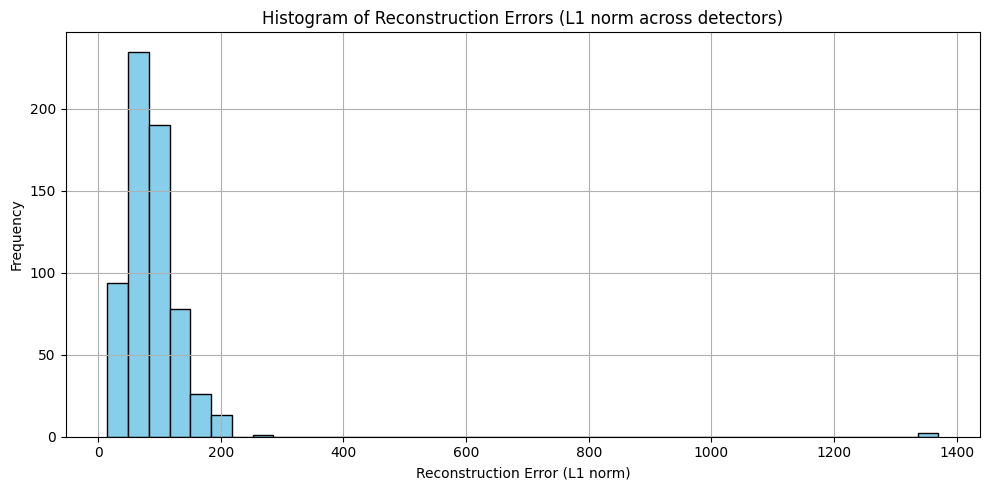

In [ ]:
# Compute reconstruction errors (L1 norm per sample, for all detectors)
reconstruction_errors = np.sum(np.abs(mu_pred_inv - y_test_inv), axis=1)
reconstruction_errors_flat = reconstruction_errors.flatten()

plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=40, color='skyblue', edgecolor='black')
plt.title("Histogram of Reconstruction Errors (L1 norm across detectors)")
plt.xlabel("Reconstruction Error (L1 norm)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()